# Exploratory Data Analysis (EDA)

In this notebook, we explore the raw electricity load dataset to understand its structure, distributions, correlations, and potential issues such as outliers.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../data/electricity.csv")

## Dataset source and context

- Source: OpenML dataset **“Electricity Load Diagrams 2011–2014”** (ID 46214).  
- Data: aggregated smart meter readings from multiple commercial clients in Portugal.  
- Shape in this project: **105217 rows** and **319 columns**.  
- Features:
  - `value_0` to `value_315`: electricity consumption measurements
  - `id_series`: time series identifier
  - `date`: timestamp
  - `time_step`: integer time index

There are **no missing numeric values** in the meter readings, but the data is

- high dimensional (316 meter features)  
- strongly right skewed with many near zero readings  
- large in size (more than 33 million numeric values)

These properties make preprocessing and careful model design necessary.


## Initial dataset inspection

First, we load the CSV file and inspect its structure using `head()` and `info()` to understand the columns, data types, and size of the dataset.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105217 entries, 0 to 105216
Columns: 319 entries, id_series to time_step
dtypes: float64(316), int64(2), object(1)
memory usage: 256.1+ MB


## Summary statistics

To understand the range and distribution of each variable, I generate descriptive statistics. With 300+ features, this helps identify which columns show higher variance or potential outliers.

In [2]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id_series,105217.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
value_0,105217.0,5.293122,6.382257,0.0,1.269036,2.538071,5.076142,48.223350
value_1,105217.0,27.684728,6.583655,0.0,23.470839,27.738265,32.005690,115.220484
value_2,105217.0,3.890152,12.567376,0.0,1.737619,1.737619,2.606429,151.172893
value_3,105217.0,109.553284,39.043562,0.0,83.333333,99.593496,128.048780,321.138211
...,...,...,...,...,...,...,...,...
value_312,105217.0,12.356675,9.777768,0.0,5.851375,8.777063,14.043300,60.269163
value_313,105217.0,565.549464,142.894740,0.0,492.537313,579.455663,654.960492,1138.718174
value_314,105217.0,126.242954,67.921538,0.0,58.430718,123.539232,175.292154,362.270451
value_315,105217.0,833.470895,140.024961,0.0,728.005865,816.715543,909.824047,1549.120235


### Summary statistics interpretation

- Most meter features have medians close to zero, which indicates sparse or low usage for long periods.  
- Maximum values vary widely across meters, showing the presence of strong outliers.  
- Standard deviations differ a lot across features, so some meters are very volatile while others are almost flat.  
- All meter readings are non negative and there are **no missing numeric values** in the cleaned data.

For this project the target is continuous (`value_0`), so there is **no class imbalance issue**.  
Instead, the main challenges are skewed distributions, outliers, and very different feature scales.


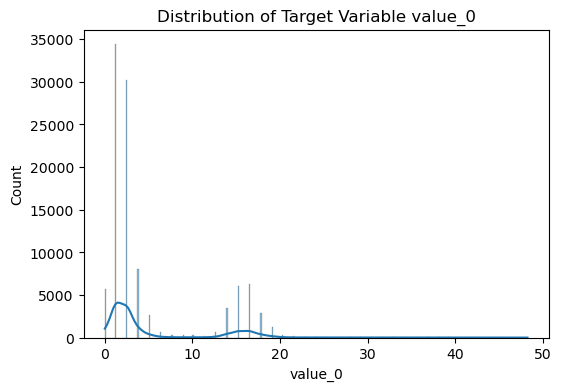

In [8]:
plt.figure(figsize=(6,4))
sns.histplot(df["value_0"], kde=True)
plt.title("Distribution of Target Variable value_0")
plt.xlabel("value_0")
plt.ylabel("Count")
plt.show()


### Target Distribution Observation
The target variable value_0 is heavily right-skewed with many repeated low readings. 
This confirms that the dataset contains sparse and irregular consumption patterns, supporting the need for normalization and nonlinear models.


## Correlation Analysis

Next, we compute correlations between each feature and the target variable (`value_0`).  
This shows which features are most strongly related to the target and may be useful for predictive modeling.  

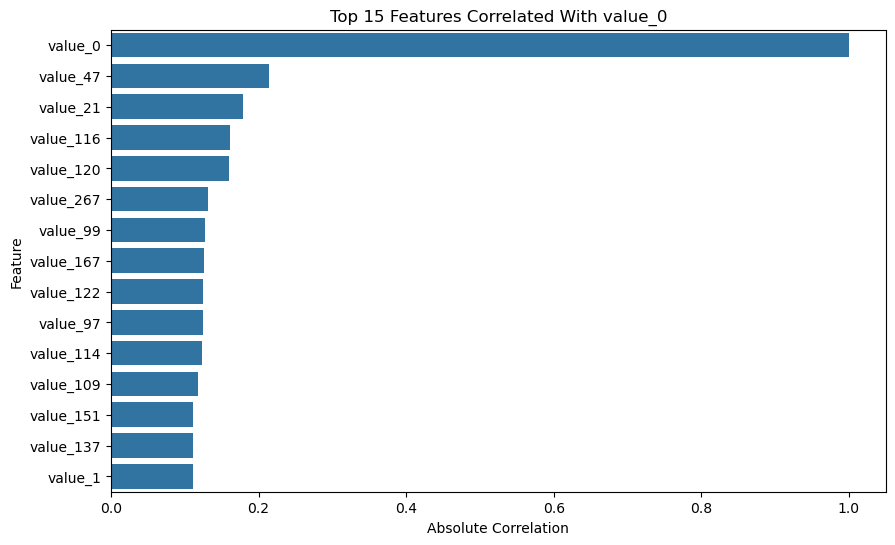

In [5]:
target = "value_0"
corr = (
    df.corr(numeric_only=True)[target]
    .abs()
    .sort_values(ascending=False)
    .head(15)
)

plt.figure(figsize=(10,6))
sns.barplot(x=corr.values, y=corr.index)
plt.title("Top 15 Features Correlated With value_0")
plt.xlabel("Absolute Correlation")
plt.ylabel("Feature")
plt.show()


### Interpretation of Correlation Barplot
The correlation barplot shows that none of the other meters have a strong linear relationship with `value_0`. 
All correlations besides `value_0` itself are below 0.22 which means that linear predictive power is very weak.

This indicates:
- No single feature can predict the target.
- Linear models will struggle.
- Nonlinear models are required.


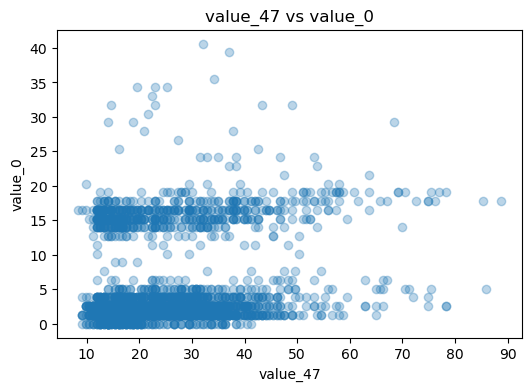

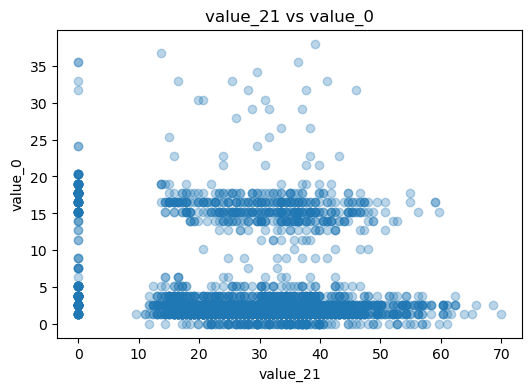

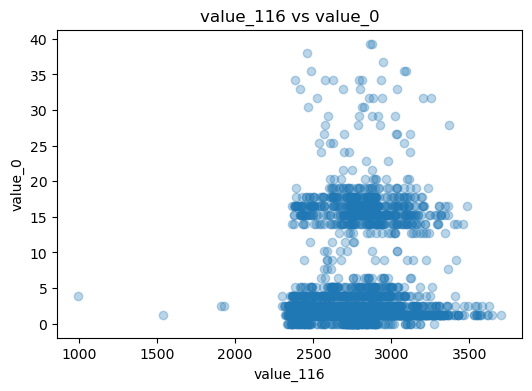

In [9]:
top_features = corr.index[1:4]  # skip value_0 itself

for f in top_features:
    plt.figure(figsize=(6,4))
    sample_df = df[[f, target]].sample(3000)
    plt.scatter(sample_df[f], sample_df[target], alpha=0.3)
    plt.title(f"{f} vs {target}")
    plt.xlabel(f)
    plt.ylabel(target)
    plt.show()


### Scatterplot Interpretation
These scatterplots reveal:
- Strong nonlinear relationships.
- Horizontal banding due to repeated meter readings.
- No clear linear pattern between predictors and `value_0`.

This explains:
- Why the baseline linear regression model underperforms.
- Why methods like SRP and Gradient Boosting are appropriate.


## EDA conclusion and modeling implications

From the plots and summaries above we see that the dataset is

- high dimensional  
- strongly right skewed and sparse  
- dominated by nonlinear relationships between meters  
- affected by outliers and very different feature scales

These findings have direct consequences for the models we use:

- **Normalization** is required so that large scale meters do not dominate training.  
- **Plain Linear Regression** will mainly serve as a baseline, because weak linear correlations and nonlinear scatterplots show that a simple line cannot capture the structure.  
- **Regularized linear models** (Ridge and Lasso) benefit from normalized features and help control high dimensionality.  
- **Dimensionality reduction** with Sparse Random Projection (SRP) is needed to compress the 316 meter features before training more flexible models.  
- **Nonlinear models** such as Gradient Boosting Regressor are better suited to the complex patterns revealed in the scatterplots.  
- Clear hourly and daily patterns in the target motivate a later **time series forecasting** step with lag and cyclical features.

Together this connects the EDA directly to our modeling choices in the rest of the project.
